In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install prophet

In [15]:
!pip install pystan==2.18.0.0
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 17.5 MB 31.5 MB/s 
  Created wheel for pystan: filename=pystan-2.18.0.0-cp38-cp38-linux_x86_64.whl size=56934979 sha256=6b01c82ad625a584973a7480e96fac02e4cc27f839e405a9b08991cda25332ad
  Stored in directory: /root/.cache/pip/wheels/c9/8d/a0/87147a86c11b867cb8e500fa47c9dd551624c336159f4a7b9f
Successfully built pystan
  Attempting uninstall: pystan
    Found existing installation: pystan 3.3.0
    Uninstalling pystan-3.3.0:
      Successfully uninstalled pystan-3.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=6305577 sha256=8c587ef3d28220eae04739d9872b4bd0d201ab3a3e27b2328a0e2629332a3780
  Stored in directory: /root/.cache/pip/wheels/d0/d2/ae/c579b7fd160999d35908f3cb8ebcad7e

Import libraries and data

In [16]:
#Libraries
import itertools
from fbprophet import Prophet
import pandas as pd
import numpy as np

In [19]:
#Data
df = pd.read_csv(r"/content/drive/MyDrive/Datasc/Forecasting Models and Time Series for Business in Python/Daily Bike Sharing.csv")
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [20]:
#Select variables
dataset = df.loc[:,["dteday","cnt", "holiday", "workingday", "weathersit", "temp", "atemp",
                   "hum", "windspeed"]]
dataset.head(1)

,dteday,cnt,holiday,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,985,0,0,2,0.344167,0.363625,0.805833,0.160446


Data transformation

In [21]:
#Date variable (La variable en la columna dteday tiene tipo object -> transformar en datetime)
dataset.dteday = pd.to_datetime(dataset.dteday,
                                format = "%Y-%m-%d")
dataset.dteday

0     2011-01-01
1     2011-01-02
2     2011-01-03
3     2011-01-04
4     2011-01-05
         ...    
726   2012-12-27
727   2012-12-28
728   2012-12-29
729   2012-12-30
730   2012-12-31
Name: dteday, Length: 731, dtype: datetime64[ns]

In [22]:
#Renaming variable
dataset = dataset.rename(columns = {"cnt" : "y"})
dataset = dataset.rename(columns = {"dteday" : "ds"})
dataset.head(1)

,ds,y,holiday,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,985,0,0,2,0.344167,0.363625,0.805833,0.160446


Holidays

In [27]:
holiday_dates = dataset[dataset.holiday == 1].ds
holidays = pd.DataFrame({"holiday": "holi", 
                         "ds": pd.to_datetime(holiday_dates), #Días de holiday
                         "lower_window": -3, #Cuando días antes del holiday
                         "upper_window": 1}) #Cuantos días después del holiday
                        
holidays.head()

,holiday,ds,lower_window,upper_window
16,holi,2011-01-17,-3,1
51,holi,2011-02-21,-3,1
104,holi,2011-04-15,-3,1
149,holi,2011-05-30,-3,1
184,holi,2011-07-04,-3,1


In [28]:
#Removing holiday column
dataset = dataset.drop(columns = "holiday")
dataset.head()

,ds,y,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,985,0,2,0.344167,0.363625,0.805833,0.160446
1,2011-01-02,801,0,2,0.363478,0.353739,0.696087,0.248539
2,2011-01-03,1349,1,1,0.196364,0.189405,0.437273,0.248309
3,2011-01-04,1562,1,1,0.200000,0.212122,0.590435,0.160296
4,2011-01-05,1600,1,1,0.226957,0.229270,0.436957,0.186900


Training and test Set

In [29]:
#Training and test set ( test van a ser los últimos 31 días del dataset)
test_days = 31
training_set = dataset.iloc[:-test_days, :] #todo menos los últimos 31 días
test_set = dataset.iloc[-test_days:, :]

Facebook prophet

In [30]:
#Facebook prophet model
m = Prophet(growth= "linear",
            yearly_seasonality= True,
            weekly_seasonality= True,
            daily_seasonality= False,
            holidays = holidays,
            seasonality_mode= "multiplicative",
            seasonality_prior_scale= 10,
            holidays_prior_scale= 10,
            changepoint_prior_scale= 0.05)

m.add_regressor("workingday")
m.add_regressor("weathersit")
m.add_regressor("temp")
m.add_regressor("atemp")
m.add_regressor("hum")
m.add_regressor("windspeed")

m.fit(training_set)

In [33]:
#Create future dataframe
future = m.make_future_dataframe (periods= len (test_set),
                                  freq = "D")
future.tail()
  #Solo genera fechas

#Merge regressors
future = pd.concat([future, dataset.iloc[:,2:]],
                   axis = 1)

future.head(1)

,ds,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,0,2,0.344167,0.363625,0.805833,0.160446


In [34]:
#forecast
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,atemp,atemp_lower,atemp_upper,extra_regressors_multiplicative,...,workingday,workingday_lower,workingday_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2011-01-01,1846.995799,111.955277,1948.029204,1846.995799,1846.995799,-0.041031,-0.041031,-0.041031,-0.300723,...,0.000000,0.000000,0.000000,-0.263782,-0.263782,-0.263782,0.0,0.0,0.0,1033.891095
1,2011-01-02,1855.961708,-40.499372,1761.474098,1855.961708,1855.961708,-0.044485,-0.044485,-0.044485,-0.305601,...,0.000000,0.000000,0.000000,-0.256492,-0.256492,-0.256492,0.0,0.0,0.0,846.955881
2,2011-01-03,1864.927618,125.782037,2009.319297,1864.927618,1864.927618,-0.101892,-0.101892,-0.101892,-0.109895,...,0.121953,0.121953,0.121953,-0.247927,-0.247927,-0.247927,0.0,0.0,0.0,1098.494198
3,2011-01-04,1873.893527,237.942461,2096.349144,1873.893527,1873.893527,-0.093956,-0.093956,-0.093956,-0.102328,...,0.121953,0.121953,0.121953,-0.238204,-0.238204,-0.238204,0.0,0.0,0.0,1190.819174
4,2011-01-05,1882.859436,431.034954,2215.144549,1882.859436,1882.859436,-0.087966,-0.087966,-0.087966,-0.029965,...,0.121953,0.121953,0.121953,-0.227461,-0.227461,-0.227461,0.0,0.0,0.0,1338.212793


In [35]:
#Predictions
predictions_prophet = forecast.yhat[-test_days:].rename ("prophet")
predictions_prophet.head()

700    4162.183107
701    3512.547794
702    5690.876334
703    5698.594960
704    5397.015625
Name: prophet, dtype: float64

###Viz

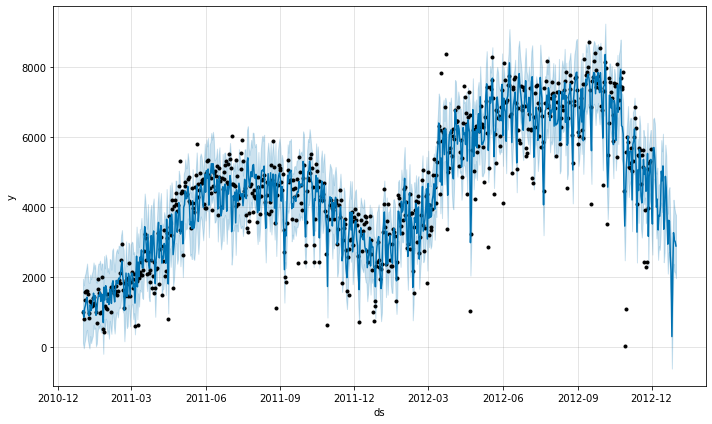

In [37]:
#visualization forecast
m.plot(forecast);

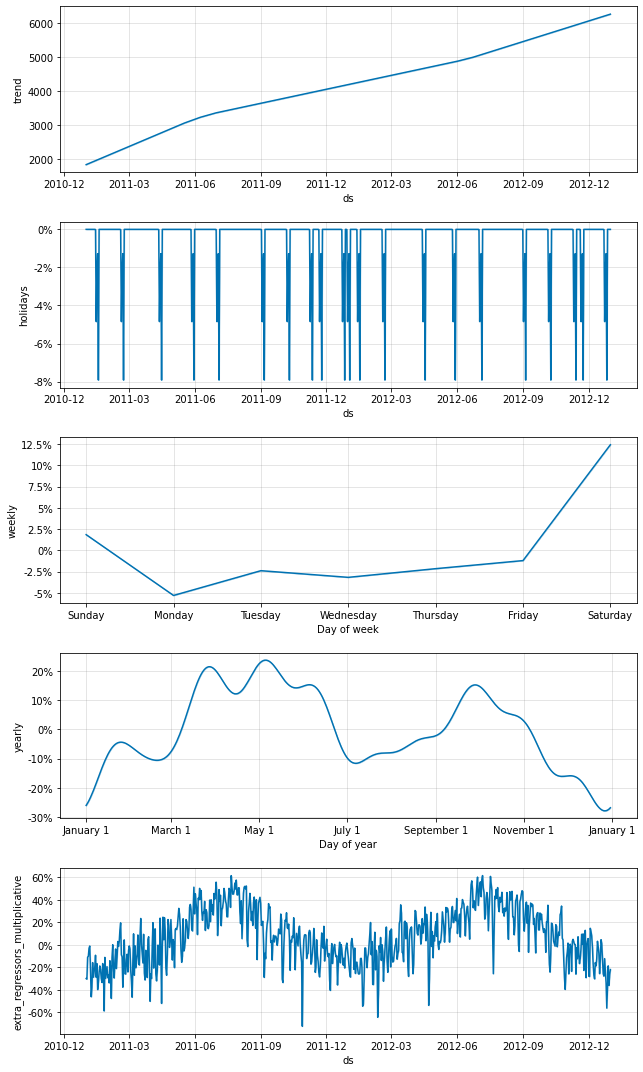

In [39]:
#plot components
m.plot_components(forecast);

Model assessment

In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(round(mean_absolute_error(test_set["y"], predictions_prophet),0))
print(round(np.sqrt(mean_squared_error(test_set["y"], predictions_prophet)),0))

858.0
1024.0


In [41]:
#MAPE function
def MAPE (y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/ y_true))*100
MAPE(test_set["y"], predictions_prophet)

34.549252407517244

#Cross-validation

In [43]:
#CV
from fbprophet.diagnostics import cross_validation

df_cv = cross_validation (m, 
                          horizon = "31 days",
                          initial = "540 days",
                          parallel = "processes")

df_cv.head()

INFO:fbprophet:Making 9 forecasts with cutoffs between 2012-06-28 00:00:00 and 2012-10-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc793bd6df0>


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-06-29,8179.704641,7400.545555,8940.604790,5463,2012-06-28
1,2012-06-30,7239.339627,6423.073989,7990.060867,5687,2012-06-28
2,2012-07-01,7446.915089,6655.868879,8195.898058,5531,2012-06-28
3,2012-07-02,6803.387485,6031.567989,7517.506353,6227,2012-06-28
4,2012-07-03,7449.190030,6726.157298,8228.490827,6660,2012-06-28


In [44]:
#Evaluation

print(round(mean_absolute_error(df_cv["y"], df_cv["yhat"]),0))
print(round(np.sqrt(mean_squared_error(df_cv["y"], df_cv["yhat"])),0))
print(MAPE(df_cv["y"], df_cv["yhat"]))

1006.0
1268.0
126.56479690629278


#Hyperparameter tuning

In [48]:
#Parameter grid
from sklearn.model_selection import ParameterGrid
param_grid = {"seasonality_prior_scale": [5, 10, 20],
              "changepoint_prior_scale": [0.01, 0.05, 0.1],
              "holidays_prior_scale": [5, 10, 20]}
grid = ParameterGrid(param_grid)

list (grid)[:3]

{'changepoint_prior_scale': 0.01,
 'holidays_prior_scale': 10,
 'seasonality_prior_scale': 5}

In [ ]:
#Hyperparameter tuning
rmse = []
for params in grid:  
  #build model
  m = Prophet(growth= "linear",
            yearly_seasonality= True,
            weekly_seasonality= True,
            daily_seasonality= False,
            holidays = holidays,
            seasonality_mode= "multiplicative",
            seasonality_prior_scale= params["seasonality_prior_scale"],
            holidays_prior_scale= params["changepoint_prior_scale"],
            changepoint_prior_scale= params["holidays_prior_scale"])

  m.add_regressor("workingday")
  m.add_regressor("weathersit")
  m.add_regressor("temp")
  m.add_regressor("atemp")
  m.add_regressor("hum")
  m.add_regressor("windspeed")

  m.fit(training_set)

  #Cross-validation
  df_cv = cross_validation (m, 
                          horizon = "31 days",
                          initial = "540 days",
                          parallel = "processes")
  #Gather the results
  error = np.sqrt(mean_squared_error(df_cv["y"], 
                                     df_cv["yhat"]))
  rmse.append(error)

In [51]:
#best parameters
best_params = grid[np.argmin(rmse)]
print(best_params, np.argmin(rmse))

{'seasonality_prior_scale': 5, 'holidays_prior_scale': 5, 'changepoint_prior_scale': 0.1} 18


#Final Prophet Model

In [52]:
#Build model
m = Prophet(growth= "linear",
            yearly_seasonality= True,
            weekly_seasonality= True,
            daily_seasonality= False,
            holidays = holidays,
            seasonality_mode= "multiplicative",
            seasonality_prior_scale= best_params["seasonality_prior_scale"],
            holidays_prior_scale= best_params["changepoint_prior_scale"],
            changepoint_prior_scale= best_params["holidays_prior_scale"])

m.add_regressor("workingday")
m.add_regressor("weathersit")
m.add_regressor("temp")
m.add_regressor("atemp")
m.add_regressor("hum")
m.add_regressor("windspeed")

m.fit(training_set)

In [53]:
#Create future dataframe
future = m.make_future_dataframe (periods= len (test_set),
                                  freq = "D")

  #Solo genera fechas

#Merge regressors
future = pd.concat([future, dataset.iloc[:,2:]],
                   axis = 1)

future.head(1)

,ds,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,0,2,0.344167,0.363625,0.805833,0.160446


In [54]:
#Forecast
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,atemp,atemp_lower,atemp_upper,extra_regressors_multiplicative,...,workingday,workingday_lower,workingday_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2011-01-01,2959.092244,298.387718,1875.968286,2959.092244,2959.092244,-0.048522,-0.048522,-0.048522,-0.282380,...,0.000000,0.000000,0.000000,-0.449596,-0.449596,-0.449596,0.0,0.0,0.0,1084.553777
1,2011-01-02,2944.457964,-0.057654,1663.264071,2944.457964,2944.457964,-0.052606,-0.052606,-0.052606,-0.276311,...,0.000000,0.000000,0.000000,-0.441050,-0.441050,-0.441050,0.0,0.0,0.0,875.987389
2,2011-01-03,2929.823684,342.782554,1933.848452,2929.823684,2929.823684,-0.120493,-0.120493,-0.120493,-0.145772,...,0.097763,0.097763,0.097763,-0.431258,-0.431258,-0.431258,0.0,0.0,0.0,1102.653230
3,2011-01-04,2915.189404,390.535505,1996.192039,2915.189404,2915.189404,-0.111108,-0.111108,-0.111108,-0.149223,...,0.097763,0.097763,0.097763,-0.420324,-0.420324,-0.420324,0.0,0.0,0.0,1204.555348
4,2011-01-05,2900.555124,592.988755,2233.245963,2900.555124,2900.555124,-0.104024,-0.104024,-0.104024,-0.073458,...,0.097763,0.097763,0.097763,-0.408372,-0.408372,-0.408372,0.0,0.0,0.0,1436.002582


In [57]:
#Predictions
predictions_prophet_tuned = forecast.yhat[-test_days:].rename ("prophet_tuned")
predictions_prophet_tuned.index = test_set["ds"]
predictions_prophet_tuned.head()

ds
2012-12-01    3935.844921
2012-12-02    3193.061371
2012-12-03    6428.134912
2012-12-04    6640.412606
2012-12-05    6411.720172
Name: prophet_tuned, dtype: float64

Export forecast

In [ ]:
predictions_X.to_csv("3_predictions_X.csv", index = True)